# Multimodal Data Fusion - Project Work: Multi-Modal Physical Exercise Classification


In this project, real multi-modal data is studied by utilizing different techniques presented during the course. In addition, there is an optional task to try some different approaches to identify persons from the same dataset. Open MEx dataset from UCI machine learning repository is used. Idea is to apply different techniques to recognize physical exercises from wearable sensors and depth camera, user-independently.

## Author(s)
Add your information here

Name: Lauri Heikka

Student number: 2317500

## Description 

The goal of this project is to develop user-independent pre-processing and classification models to recognize 7 different physical exercises measured by accelerometer (attached to subject's thigh) and depth camera (above the subject facing downwards recording an aerial view). All the exercises were performed subject lying down on the mat. Original dataset have also another acceleration sensor and pressure-sensitive mat, but those two modalities are ommited in this project. There are totally 30 subjects in the original dataset, and in this work subset of 10 person is utilized. Detailed description of the dataset and original data can be access in [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#). We are providing the subset of dataset in Moodle.

The project work is divided on following phases:

1. Data preparation, exploration, and visualization
2. Feature extraction and unimodal fusion for classification
3. Feature extraction and feature-level fusion for multimodal classification
4. Decision-level fusion for multimodal classification
5. Bonus task: Multimodal biometric identification of persons

where 1-4 are compulsory (max. 10 points each), and 5 is optional to get bonus points (max. 5+5 points). In each phase, you should visualize and analyse the results and document the work and findings properly by text blocks and figures between the code. <b> Nice looking </b> and <b> informative </b> notebook representing your results and analysis will be part of the grading in addition to actual implementation.

The results are validated using confusion matrices and F1 scores. F1 macro score is given as 
<br>
<br>
$
\begin{equation}
F1_{macro} = \frac{1}{N} \sum_i^N F1_i,
\end{equation}
$
<br>
<br>
where $F1_i = 2  \frac{precision_i * recall_i}{precision_i + recall_i}$, and $N$ is the number of classes.
<br>

## Learning goals 

After the project work, you should  

- be able to study real world multi-modal data
- be able to apply different data fusion techniques to real-world problem
- be able to evaluate the results
- be able to analyse the outcome
- be able to document your work properly

## Relevant lectures

Lectures 1-8

## Relevant exercises

Exercises 0-6

## Relevant chapters in course book

Chapter 1-14

## Additional Material 

* Original dataset [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#)
* Related scientific article [MEx: Multi-modal Exercises Dataset for Human Activity Recognition](https://arxiv.org/pdf/1908.08992.pdf)

# 1. Data preparation, exploration, and visualization

<a id='task1'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 1.</b>

Download data from the Moodle's Project section. Get yourself familiar with the folder structure and data. You can read the data files using the function given below. Each file consists one exercise type performed by single user. Data are divided on multiple folders. Note that, in each folder there is one long sequence of single exercise, except exercise 4 which is performed two times in different ways. Those two sequences belongs to same class. Do the following subtasks to pre-analyse data examples and to prepare the training and testing data for next tasks:
<br>
<br> 
<p> <b>1.1</b> Read raw data from the files. Prepare and divide each data file to shorter sequences using windowing method. Similar to related article "MEx: Multi-modal Exercises Dataset for Human Activity Recognition", use 5 second window and 3 second overlapping between windows, producing several example sequences from one exercise file for classification purposes. Windowing is working so that starting from the beginning of each long exercise sequence, take 5 seconds of data points (from synchronized acceleration data and depth images) based on the time stamps. Next, move the window 2 seconds forward and take another 5 seconds of data. Then continue this until your are at the end of sequence. Each window will consists 500x3 matrix of acceleration data and 5x192 matrix of depth image data.</p>
<br>  
<p> <b>1.2</b> Plot few examples of prepared data for each modalities (accelometer and depth camera). Plot acceleration sensor as multi-dimensional time-series and depth camera data as 2D image. Plot 5 second acceleration sensor and depth image sequences of person 1 and 5 performing exercises 2, 5, and 6. Take the first windowed example from the long exercise sequence. </p>
<br>
<p> <b>1.3</b> Split the prepared dataset to training and testing datasets so that data of persons 1-7 are used for training and data of persons 8-10 are used for testing. In next tasks, training dataset could be further divided on (multiple) validation data folds to tune the models parameters, when needed.<br>
<br> 
Document your work, calculate the indicator statistics of training and testing datasets (number of examples, dimensions of each example) and visualize prepared examples.

</div>

In [1]:
import numpy as np
import pandas as pd
from os import listdir,getcwd
    
#Reads data from the folders
def read_data_from_folders(folder_name, ID, outputform):
    output = np.empty(outputform, dtype=object)
    
    for n in range(len(ID)):
        #check files in folder.
        currentDir = getcwd()
        filepath = "%s/%s/%02d" %(currentDir, "MEx/" + folder_name, ID[n])
        files = sorted(listdir(filepath))
        count = 0
        for f in files:
            file = filepath + "/" + f
            data = pd.read_csv(file, delimiter=',', header=None)
            output[n,count] = data 
            count += 1
            
    return output

folders = ['act', 'dc_0.05_0.05']

allData = []
num = 0
ids = np.arange(1,11)

for fol in folders:
    allData.append(read_data_from_folders(fol, ids, (10,8)))

The data is now loaded into a nested array structure containing pandas dataframes. One intuitive way to set up the windowed sampling is to restructure the data to two pandas dataframes (one for each modality) with separate id columns allowing us to differentiate between different subjects, exercises and windows. Working with pandas dataframes is generally more convenient and faster than iterating over lists of dataframes.

Note that the approach taken here introduces redundant data as overlapping observations are stored separately for each window. A memory-preserving alternative would be to store the sample indices separately and reference the original data. However, the dataset is small enough to fit into memory easily, and using the index approach would introduce unnecessary complexity to wrangling the data later.

We first create a simple window sampling function, that takes in a single dataframe and constructs a dataframe consisting of windowed observations. 

In [2]:
def window_sample(df_a, df_d, window=5000, increment=2000):
    # initialize the array of temporary dfs
    temp_dfs_a = []
    temp_dfs_d = []
    
    start = df_a[0].min()
    # iterate through time window values
    while start+window <= max(df_a[0].max(), df_d[0].max()):
        # get the observations for the window
        temp_df_a = df_a[(df_a[0] >= start)&(df_a[0] < (start+5000))].copy()
        temp_df_d = df_d[(df_d[0] >= start)&(df_d[0] < (start+5000))].copy()
        # check if length of dataframes are equal to window / sampling frequency in ms
        # i.e. we have a full window of observations
        if len(temp_df_a) == window // 10 and len(temp_df_d) == window // 1000:
            temp_dfs_a.append(temp_df_a)
            temp_dfs_d.append(temp_df_d)
        # store window starting time as column
        temp_df_a['win'] = start
        temp_df_d['win'] = start
        # increment the starting position by given increment
        start += increment
    # concatenate the list of dataframes to a single dataframe
    return pd.concat(temp_dfs_a), pd.concat(temp_dfs_d)

Next we iterate over the nested lists of dataframes, creating windowed representations and concatenating. This is done separately for acceleration data (allData[0]) and the depth camera data (allData[1]).

In [3]:
# initiate lists of dataframes
accelData = []
depthData = []
for i in range(len(allData[0])):
    for j in range(len(allData[0][i])):
        # get dataframes for acceleration and depth camera data
        accelDf = allData[0][i][j]
        depthDf = allData[1][i][j]
        
        #create subject and exercise id columns
        accelDf['subjectId'] = i+1
        depthDf['subjectId'] = i+1
        accelDf['exerciseId'] = j+1
        depthDf['exerciseId'] = j+1
        
        # sample and append to list
        accelDf, depthDf = window_sample(accelDf, depthDf)
        accelData.append(accelDf)
        depthData.append(depthDf)

# merge to single dataframes
accelData = pd.concat(accelData)
depthData = pd.concat(depthData)

Because exercise 4 is divided into two different data files, the exercise is currently codified with both exerciseId = 4 and exerciseId = 5. To correct for this, we subtract 1 from all exerciseIds larger than 4. This shifts the second part of exercise 4, as well as exercises 5-7 to their correct values. In addition, because the window information is codified by exerciseId, subjectId and the window position, we need to shift the window position for the second part of exercise 4 to a non-overlapping region. Adding 100000 to the window position column accomplishes this.


In addition we create a tsId column, as a combination of the subjectId, exerciseId and window start columns. The column is redundant but makes it more convenient to uniquely identify the windows.

In [4]:
accelData.loc[accelData.exerciseId == 5, 'win'] += 100000
depthData.loc[depthData.exerciseId == 5, 'win'] += 100000

accelData.loc[accelData.exerciseId > 4, 'exerciseId'] -= 1
depthData.loc[depthData.exerciseId > 4, 'exerciseId'] -= 1

accelData['tsId'] = accelData.subjectId.astype(str)+'_'+\
        accelData.exerciseId.astype(str)+'_'+\
        accelData.win.astype(int).astype(str).str.zfill(6)
depthData['tsId'] = depthData.subjectId.astype(str)+'_'+\
        depthData.exerciseId.astype(str)+'_'+\
        depthData.win.astype(int).astype(str).str.zfill(6)

To get a feel for the data, we plot some examples from the dataset.
The first 5 second window from subjects 1 and 5 performing exercises 2, 5, and 6 are shown.

We can identify the correct window by specifying the corresponding tsId, which codifies the corresponding subject number, exercise number and the window position.

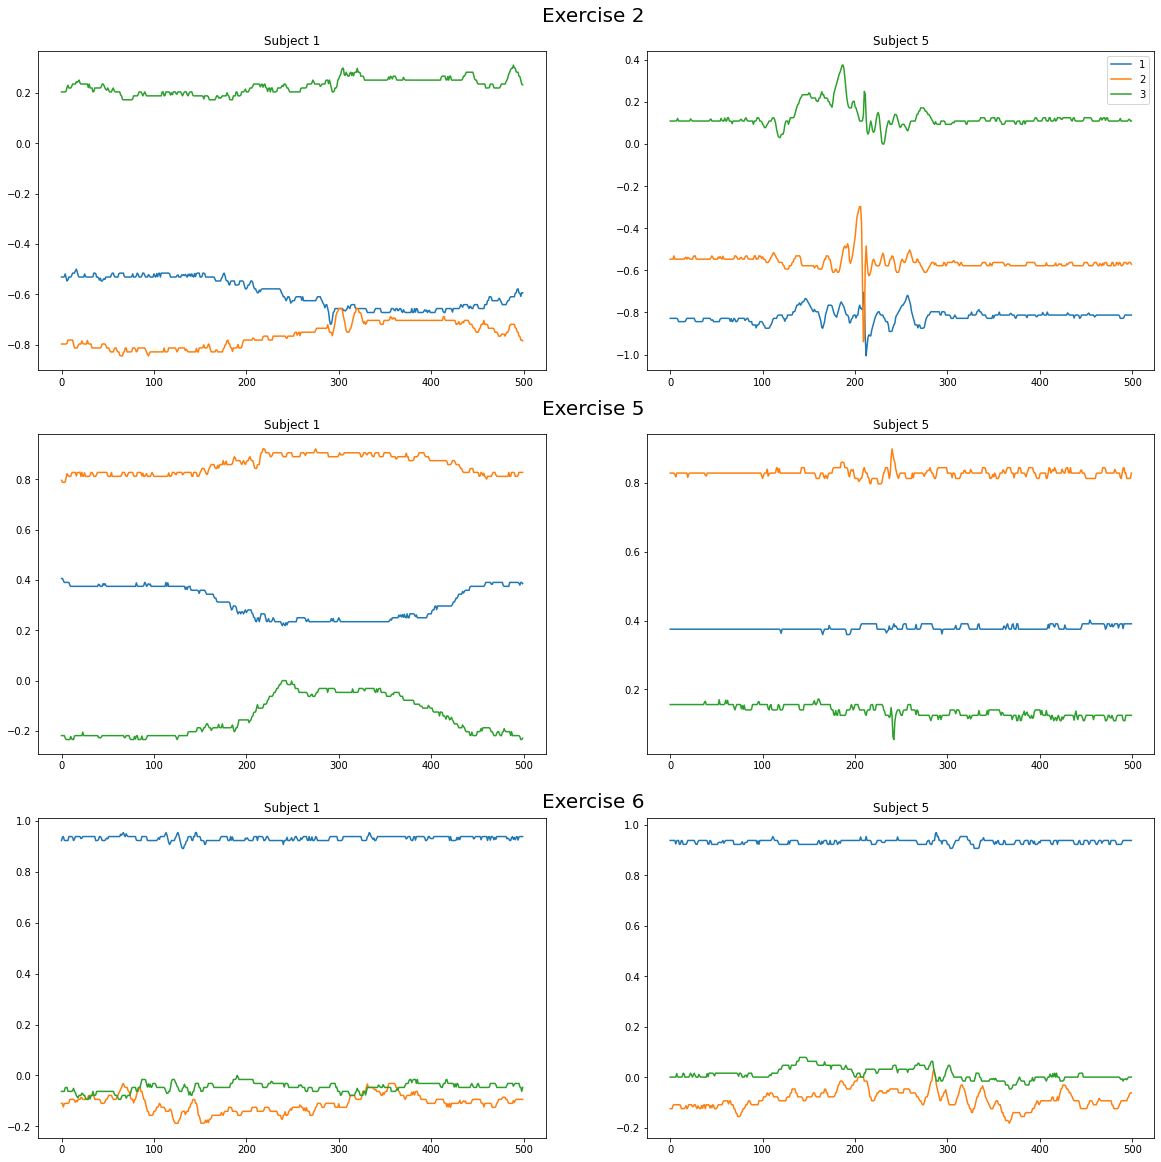

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,2, figsize=(20,20))
j = 0
# exercises 256
for i in [2,5,6]:
    # we plot legend to one image
    legend = i == 2
    # plot the three series from selected exercise for subject 1
    accelData.loc[accelData.tsId == f'1_{i}_000000',[1,2,3]].plot(ax=ax[j,0], legend=False)
    # for subject 5
    accelData.loc[accelData.tsId == f'5_{i}_000000',[1,2,3]].plot(ax=ax[j,1], legend=legend)
    ax[j, 0].set_title(f'Subject 1', size='large')
    ax[j, 1].set_title(f'Subject 5',size='large')
    # add a shared row title
    plt.figtext(0.475, .9-j/3.667, f'Exercise {i}', fontsize=20)
    j+=1

The acceleration data used here is measured from an accelerometer placed on the thigh of the subject. The three series represent acceleration on three axis. As could be expected, the acceleration on the different axes are correlated at times. The data appears to have some noise, but not enough to cause concern.

Next, we plot 5 depth camera images from the same of the windows.

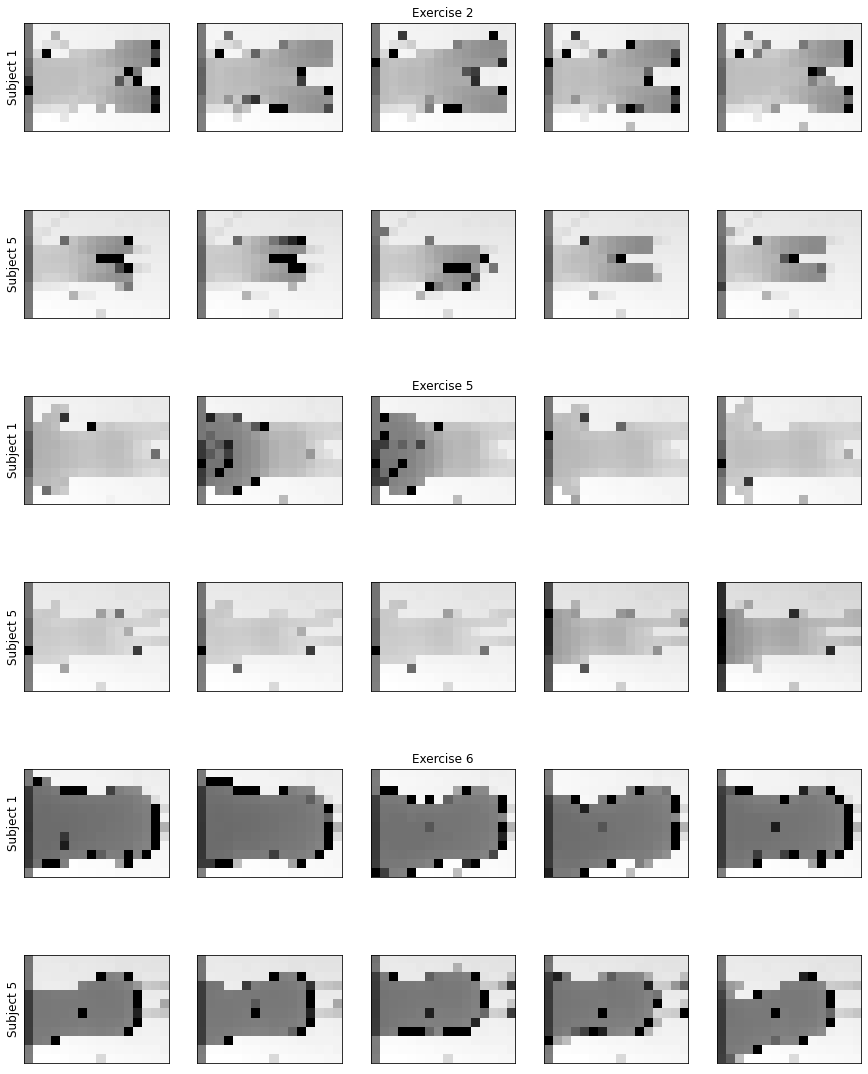

In [6]:
fig, ax = plt.subplots(6,5, figsize=(15,20))
imgs = 5
# iterate over exercises 2,5,6. i is for selecting correct image, j for correct axis row
for j, i in enumerate([2,5,6]):
    # get the 5 images for the window
    images = depthData.loc[depthData.tsId == f'1_{i}_000000',range(1,193)].values
    # for the 5 images in the window, reshape and plot with imshow
    for im_n in range(imgs):
        image = images[im_n,:].reshape(12,16)
        ax[j*2,im_n].imshow(image, cmap='gray')
        ax[j*2,im_n].set_xticks([])
        ax[j*2,im_n].set_yticks([])
    ax[j*2,0].set_ylabel('Subject 1', size='large')
    # repeat for subject 5
    images = depthData.loc[depthData.tsId == f'5_{i}_000000',range(1,193)].values
    for im_n in range(imgs):
        image = images[im_n,:].reshape(12,16)
        ax[j*2+1,im_n].imshow(image, cmap='gray')
        ax[j*2+1,im_n].set_xticks([])
        ax[j*2+1,im_n].set_yticks([])
    ax[j*2+1,0].set_ylabel('Subject 5', size='large')
    ax[j*2, 2].set_title(f'Exercise {i}')

The depth camera footage is taken from above the subjects, who are performing the exercises lying on the floor, and gives some guidance to the positioning of the subject during different exercises. Subjects share a similar positioning, when doing the same exercise.

One important observation here is, that the sequences do not seem to be aligned in terms of their timing. The original paper also (subsection 2.3) mentions that there were no instructions on keeping a specific rhythm.


## Splitting the data
Finally, we split the dataset to training data (subjects 1-7) and test data (subjects 8-10).

In [7]:
trainAccel = accelData[accelData.subjectId <= 7]
testAccel = accelData[accelData.subjectId > 7]
trainDepth = depthData[depthData.subjectId <= 7]
testDepth = depthData[depthData.subjectId > 7]

We need to create the training and test labels as well. For this we select one observation of the exerciseId for each of the training windows, which are indexed by tsId by dropping duplicated tsId values using .loc and pandas series duplicated method.

In [8]:
y_train = trainAccel.loc[~trainAccel.tsId.duplicated(), 'exerciseId'].values
y_test = testAccel.loc[~testAccel.tsId.duplicated(), 'exerciseId'].values

The below print statements summarize information on the training and test datasets.

Training data has 1487 examples.
Test data has 598 examples.
Each window of acceleration data has 500 observations of 5 features
Each window of depth image data has 5 194 pixel (12x16) images.
Subjects in training data:  [1 2 3 4 5 6 7]
Subjects in test data:  [ 8  9 10]
Exercises in training data:  [1 2 3 4 5 6 7]
Exercises in test data:  [1 2 3 4 5 6 7]


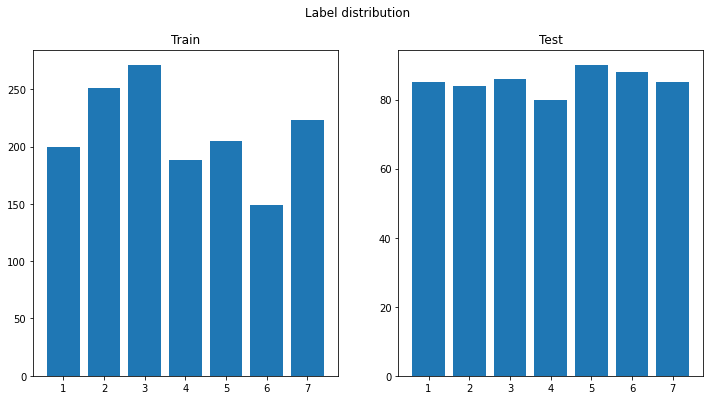

In [9]:
print(f'Training data has {len(y_train)} examples.')
print(f'Test data has {len(y_test)} examples.')  
print('Each window of acceleration data has',
      len(trainAccel[trainAccel.tsId == '1_1_000000']), 'observations of',
      len(trainAccel.columns) - 3, 'features') # -3 for tsId, exerciseId and subjectId
print('Each window of depth image data has',\
      len(trainDepth[trainDepth.tsId == '1_1_000000']),
      len(trainDepth.columns) - 3,  'pixel (12x16) images.')
print('Subjects in training data: ', trainAccel.subjectId.unique())
print('Subjects in test data: ', testAccel.subjectId.unique())
print('Exercises in training data: ', trainAccel.exerciseId.unique())
print('Exercises in test data: ', testAccel.exerciseId.unique())
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].bar(range(1,8), np.bincount(y_train-1))
ax[1].bar(range(1,8), np.bincount(y_test-1))
fig.suptitle('Label distribution')
ax[0].set_title('Train')
ax[1].set_title('Test')
plt.show()

# 2. Feature extraction and fusion for unimodal classification

<a id='task2'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 2.</b>

Use the training dataset prepared in task 1. to build models based on the combination of principal component analysis (PCA), linear discriminant analysis (LDA), and nearest neighbour (NN) classifier for each modality separately and evaluate the model on test dataset. Do the subtasks given as
<br>
<br>
<p> <b>2.1</b> Calculate PCA and LDA transformations to reduce the dimensionality of accelerometer data (e.g., using scikit-learn implementations). Before transformations downsample data from 100 Hz to 25 Hz (using scipy.signal.resample) to get 125x3 matrix of data for each 5 sec window. You should also standardize the values to zero mean and unit variance before the transformations. Using training dataset, fit PCA with 5-dimensional subspace (i.e., choosing the 5 largest principal components) and fit LDA with 5-dimensional subspace. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 3x(5+5). Perform the fusion of PCA and LDA similar manner as presented in Lecture 3 (pages-19-20) using NN method. Evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>
<br>
<p> <b>2.2</b> Use PCA and LDA transformations to reduce the dimensionality of depth images. You should also standardize the values to zero mean and unit variance before the transformations. Fit PCA and LDA for all training images (12x16, 192-dimensional in vectorized form) by choosing 5-dimensional subspace for both PCA and LDA. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 5x1x(5+5). Similar to task 2.1, do the PCA and LDA fusion using NN and evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>
<br> 
Document your work, evaluate the results, and analyse the outcomes in each subtasks 2.1-2.2.
    
</div>

We create a small helper function, that does the required resampling for each feature using scipy.signal.resample. For the PCA/LDA we use scikit-learn implementations.

In [12]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.signal import resample

def resample_accel(data, num=125):
    '''
    Input
        data: pandas dataframe of acceleration data
        num: frequency to feed into scipy.signal.resample
    '''
    resampledAccel = []
    # iterate over the three features ( 1, 2, 3)
    for i in range(1, 4):
        # create resampled series for each sampled window
        resampled = data.groupby('tsId')[i].apply(lambda x: resample(x, num=125))
        # above piece of codes results in a pandas series of numpy arrays
        # next, we stack the resampled iterations to one series
        resampled = resampled.apply(pd.Series).stack().reset_index(level=1, drop=True)
        resampledAccel.append(resampled)
    # horizontally stack the resampled series to a pandas dataframe
    resampledAccel = pd.concat(resampledAccel, axis=1)
    resampledAccel.columns = range(1,4) # revert to original column numbering
    return resampledAccel

Note that the function results in a dataframe that is indexed by tsId instead and contains only the features with subject and exerciseId dropped.

We also index the depth camera data with tsId and select only the pixel value columns.

At this point, it makes sense to review the datasets for a sanity check.

In [13]:
trainAccel = resample_accel(trainAccel)
testAccel = resample_accel(testAccel)

trainDepth = trainDepth.set_index('tsId')[range(1, 193)]
testDepth = testDepth.set_index('tsId')[range(1, 193)]

#ensure that all windows have same # of observations
assert trainAccel.groupby('tsId')[1].count().min() == trainAccel.groupby('tsId')[1].count().max()
print(trainAccel.groupby('tsId')[1].count()[1], 'observations for each window.')
trainAccel

125 observations for each window.


,1,2,3
tsId,,,
1_1_000000,-0.536889,-0.766466,0.100999
1_1_000000,-0.513372,-0.871641,-0.222329
1_1_000000,-0.514542,-0.851034,-0.180858
1_1_000000,-0.505741,-0.872516,-0.239147
1_1_000000,-0.499132,-0.851924,-0.228871
...,...,...,...
7_7_074000,-0.957142,0.323784,-0.122658
7_7_074000,-0.959383,0.208465,-0.005614
7_7_074000,-0.940037,0.226503,-0.063650


In [14]:
assert trainDepth.groupby('tsId')[1].count().min() == trainDepth.groupby('tsId')[1].count().max()
print(trainDepth.groupby('tsId')[1].count()[1], 'observations for each window.')
trainDepth

5 observations for each window.


,1,2,3,4,5,6,7,8,9,10,...,183,184,185,186,187,188,189,190,191,192
tsId,,,,,,,,,,,,,,,,,,,,,
1_1_000000,0.4583,0.9214,0.9221,0.9167,0.9136,0.9136,0.9106,0.9075,0.9052,0.8999,...,0.9479,0.9460,0.9429,0.6804,0.9360,0.9360,0.9360,0.9329,0.9260,0.9279
1_1_000000,0.4591,0.9214,0.9198,0.9167,0.9136,0.9136,0.9113,0.9075,0.9060,0.8999,...,0.9489,0.9460,0.9429,0.9167,0.9360,0.9360,0.9352,0.9329,0.9269,0.9279
1_1_000000,0.4583,0.9214,0.9206,0.9167,0.9136,0.9136,0.9106,0.9075,0.9044,0.7163,...,0.9460,0.9452,0.9429,0.7043,0.9360,0.9360,0.9352,0.9329,0.9260,0.9260
1_1_000000,0.4591,0.9214,0.9206,0.9167,0.9136,0.9136,0.9106,0.9075,0.9060,0.8999,...,0.9479,0.9452,0.9429,0.6810,0.9360,0.9360,0.9352,0.9329,0.9279,0.9288
1_1_000000,0.4591,0.9214,0.9214,0.9167,0.9144,0.9128,0.9113,0.9075,0.9060,0.8993,...,0.9460,0.9452,0.9429,0.9165,0.9368,0.6546,0.6284,0.0000,0.9279,0.9260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7_7_074000,0.4323,0.8645,0.8615,0.8585,0.8585,0.8555,0.8555,0.8555,0.8518,0.8503,...,0.9404,0.9389,0.8079,0.9337,0.9337,0.9308,0.9270,0.9308,0.9241,0.9222
7_7_074000,0.4330,0.8645,0.8615,0.8585,0.8585,0.8570,0.8555,0.8555,0.8526,0.8511,...,0.9404,0.9404,0.8097,0.9337,0.9308,0.9289,0.9299,0.9289,0.9241,0.9232
7_7_074000,0.4330,0.8645,0.8615,0.8585,0.8585,0.8570,0.8555,0.8548,0.8526,0.8503,...,0.9404,0.9389,0.6069,0.9337,0.9337,0.9308,0.9308,0.9308,0.9232,0.9222


## PCA / LDA

Next we use PCA and LDA to transform the time series representation into feature representations.

Note: Featurewise standardization is most often performed prior to PCA. This standardization is usually done to avoid over-emphasis on high variance variables. However, here we conduct the PCA/LDA on time series' of a single feature. Doing the standardization separately at each point of time in the sequence would
make little sense (and, in an unreported comparison, performs worse empirically). Because we do the standardization globally, it should be of little importance here (also confirmed by an unreported empirical comparison).


The acceleration time series are currently in a long format and need to be converted to a wide matrix where the columns represent the time series'. We implement a helper function, index_unstack that does this.

In [15]:
def pca_lda_transform(X_train, X_test, y_train=None, n_components=5, lda=False):
    '''
    Given a test and training set and n_components, performs PCA and LDA transformations
    on the dataset.
    LDA is supervised so training it requires additionally the y_train.
    
    lda is a boolean indicator of whether to perform LDA or not. This is 
    implemented for reusability later on when we only do PCA.
    
    Returns the transformed train and test sets as np.arrays
    '''
    
    # global standardization of the data
    # np.mean and np.std on an array gives global mean and std
    # while these operations on a dataframe gives columnwise mean and std.
    # df.values gives an array representation.
    mu_x = np.mean(X_train.values) 
    sigma_x = np.std(X_train.values)
    X_train = (X_train - mu_x)/sigma_x
    X_test = (X_test - mu_x)/sigma_x # same training data values for transforming the test set
    
    # fit pca and lda
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    
    # if we have y_train values and lda is selected, perform lda as well
    if lda and y_train is not None:
        lda = LinearDiscriminantAnalysis(n_components=n_components)
        lda.fit(X_train, y_train)   
        train_transformed = np.hstack([pca.transform(X_train), lda.transform(X_train)])
        test_transformed = np.hstack([pca.transform(X_test), lda.transform(X_test)])
    else:
        train_transformed = pca.transform(X_train)
        test_transformed = pca.transform(X_test)
        
    return train_transformed, test_transformed

def index_unstack(X, num_per_window=125):
    """
    Takes in a pandas series of long data and the 
    returns the data transposed
    to a wide format where each time series observation is 
    This is done based on shared index values.
    """
    # construct an additional index level based on the frequency
    # this basically numerates the observations within each window
    index_tuples = zip(X.index, len(X)//num_per_window * [i for i in range(num_per_window)])
    X.index = pd.MultiIndex.from_tuples(index_tuples)
    # unstack based on the numeration
    return X.unstack()

For the acceleration data, PCA/LDA is intended to reduce the dimensionality of the data in the time dimension by summarising the joint variation over time across training examples.
We iterate over the 3 axis features, performing PCA/LDA separately for each one. These are appended to lists of dataframes separately for the train and test datasets, which are then stacked horizontally to create the final feature matrix with
one row for each exercise window.

In [16]:
X_train_a = []
X_test_a = []

for i in range(1,4):
    tr_X = index_unstack(trainAccel[i].copy()) # copy so that we dont alter the original dataframe
    ts_X = index_unstack(testAccel[i].copy())
    tr_X, ts_X = pca_lda_transform(tr_X, ts_X, y_train, lda=True)
    X_train_a.append(tr_X)
    X_test_a.append(ts_X)

X_train_a = np.hstack(X_train_a)
X_test_a = np.hstack(X_test_a)
print('Shapes of data')
print('Train', X_train_a.shape)
print('Test', X_test_a.shape)

Shapes of data
Train (1487, 30)
Test (598, 30)


Finally, we perform fusion on the PCA and LDA representations using the nearest neighbor method described in lecture 3 to predict the exercise label of test data. 

This means esseantially computing pairwise euclidean distances between each test data vector (rows of the test data matrix) and each training data vector (rows of the training data matrix). This is done separately for the PCA components and the LDA components. Fusion of PCA and LDA is then done by averaging the distances between the two.

In [17]:
# We need to identify the pca component and lda component columns.
pca_inds = [(i // 5)%2 == 0 for i in range(30)] # indexes for PCA components are 0-5, 10-15 and 20-25
lda_inds = [not ind for ind in pca_inds] # lda inds are the other ones

def compute_distances(x, X):
    '''
    computes euclidean distances between
    vector x and each row of training data matrix X
    scaled to range [0,1]
    '''
    d_n = ((x - X)**2).sum(1)
    d_n = (d_n - d_n.min())/(d_n.max()-d_n.min())
    return d_n

def predict_nearest(test_x, train_x, train_y, pca_inds, lda_inds):
    '''
    Takes in a test vector and the training set, as well as the column indices for
    pca components and lda components and returns the class label for the nearest neighbor, 
    based on average distance in the pca and lda spaces.
    '''
    # compute distances for pca and lda and take their average
    F_n = np.mean([compute_distances(test_x[pca_inds], train_x[:,pca_inds]),
             compute_distances(test_x[lda_inds], train_x[:,lda_inds])], 0)
    # return the class label index position of the nearest neighbor
    return train_y[F_n.argmin()]

# apply the prediction for each feature vector in X_test_a
y_pred = np.apply_along_axis(\
         lambda x: predict_nearest(x, X_train_a, y_train, pca_inds, lda_inds), 1, X_test_a)

We have computed our predictions and are ready to compute the f1 score and review the confusion matrix.

F1 Score: 0.401


C:\Users\lauri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
C:\Users\lauri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


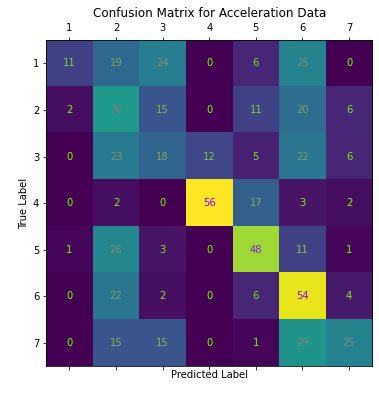

In [18]:
from sklearn.metrics import f1_score, confusion_matrix

def plot_confusion_matrix_custom(y_test, y_pred, title='Confusion matrix'):
    '''
    Function to mimic the behaviour of sklearn function plot_confusion_matrix
    but with input of test labels and predicted labels, instead of requiring an estimator object.
    '''
    conf_m = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(1, figsize=(6,6))
    ax.set_ylabel('\nTrue Label')
    ax.set_xlabel('Predicted Label\n')
    ax.set_title(title)
    for (i, j), z in np.ndenumerate(conf_m):
        cval = (z/np.max(conf_m))
        ax.text(j, i, '{:d}'.format(z), ha='center', va='center', c=[0.5, 1-cval, cval])
    ax.set_xticklabels(range(0,9))
    ax.set_yticklabels(range(0,9))
    ax.matshow(conf_m)
    return fig, ax

print('F1 Score: {:.03f}'.format(f1_score(y_test, y_pred, average='macro')))
f, ax = plot_confusion_matrix_custom(y_test, y_pred, 'Confusion Matrix for Acceleration Data')

We do not have any comparisons yet as this is the first benchmark approach. However, compared to the original paper, which reports f1 scores between 0.70 and 0.89 using only the acceleration data, the f1 score of 0.401 is unimpressive. The predictions seem to heavily favour exercises 2 and 6. As this is the first of many modeling experiments, we will not extensively diagnose.

### PCA/LDA on depth camera data

Previously, we worked on using PCA and LDA to reduce dimensionality in the time dimension to collect for each of the three different features. However, now we instead reduce the dimensionality of the pixel space of the images and do this separately for each 5 images in each training example.

There are two alternative methods to set up the dimensionality reduction. First, we can conduct the dimension reduction separately for each image in the sequence such, that images are only compared to other images at the same point in the window. This is essentially making the assumption that each image in the sequence is a separate feature and that the windows are aligned. These assumptions are inaccurate, as there is no enforced rhythm in the exercises. However, some temporal alignment may be present in e.g. the early windows, which would make this a useful reduction.

One potential implementation of this separate approach is as follows:

In [19]:
X_train_d = []
X_test_d = []
# iterate over the 5 pictures in the data
for i in range(5):
    # select every 5th image (1 for each window)
    # with i determining the starting position
    tr_X = trainDepth.iloc[i::5,]
    ts_X = testDepth.iloc[i::5,]
    #compute transformations and append
    tr_X, ts_X = pca_lda_transform(tr_X, ts_X, y_train, lda=True)
    X_train_d.append(tr_X)
    X_test_d.append(ts_X)

X_train_d = np.hstack(X_train_d)
X_test_d = np.hstack(X_test_d)
print('Shapes of data')
print('Train', X_train_d.shape)
print('Test', X_test_d.shape)

Shapes of data
Train (1487, 50)
Test (598, 50)


An alternative would be to treat the image data globally, so that all images are compared to all other images regardless of the point in time.
This can be implemented as follows:

In [20]:
# we need a new representation for the training labels for LDA. trainDepth is indexed
# by the tsId, which contains the exerciseId information.
X_train_d_global, X_test_d_global = pca_lda_transform(trainDepth, testDepth,
                                        trainDepth.index.str.split('_').str[1], n_components=5, lda=True)

X_train_d_global = np.hstack([X_train_d_global[i::5,:] for i in range(5)])
X_test_d_global = np.hstack([X_test_d_global[i::5,:] for i in range(5)])
print('Shapes of data')
print('Train', X_train_d_global.shape)
print('Test', X_test_d_global.shape)

Shapes of data
Train (1487, 50)
Test (598, 50)


Since there is no enforced temporal alignment to the exercises performed by the participants, the more intuitive solution would be to use the global transformation. However, because the main focus here is on using multimodal methods to create a working predictive model, we instead treat the selection of which method to use as an empirical exercise and compare the performance of the methods.

Next, we need to perform the fusion with the nearest neighbour method as we did previously with the acceleration data.

In [21]:
# create the indices similar as for the acceleration data but this time we have 5 x 2 x 5 components
pca_inds = [(i // 5)%2 == 0 for i in range(50)]
lda_inds = [not ind for ind in pca_inds]

# apply predictions as before
y_pred = np.apply_along_axis(lambda x: predict_nearest(x, X_train_d, y_train, pca_inds, lda_inds), 1, X_test_d)
y_pred2 = np.apply_along_axis(lambda x: predict_nearest(x, X_train_d_global, y_train, pca_inds, lda_inds),
                                      1, X_test_d_global)

print('F1 Score with local PCA/LDA: {:.03f}'.format(f1_score(y_test, y_pred, average='macro')))
print('F1 Score with global PCA/LDA: {:.03f}'.format(f1_score(y_test, y_pred2, average='macro')))

F1 Score with local PCA/LDA: 0.548
F1 Score with global PCA/LDA: 0.533


The local version seems to perform slightly better. It is possible, that there is some temporal alignment e.g. at the start of series'. The outperformance might also be small enough to be caused by randomness. For brevity, we will stick to the better performing local implementation from now on.

Both F1 scores are significantly higher than for the acceleration data. However, they still fall short of the score reported in the original paper for the depth image data, which range between 0.63 and 0.87.

C:\Users\lauri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
C:\Users\lauri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


(<Figure size 432x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Confusion Matrix for Depth Image Data'}, xlabel='Predicted Label\n', ylabel='\nTrue Label'>)

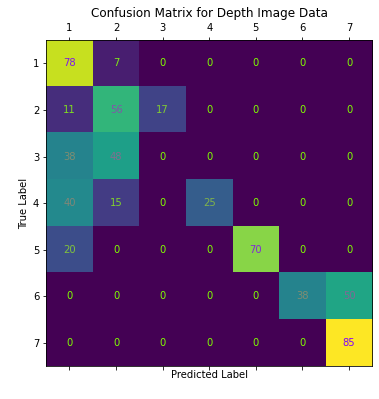

In [22]:
# we only show the confusion matrix for the btter performing alternative
plot_confusion_matrix_custom(y_test, y_pred, 'Confusion Matrix for Depth Image Data')

For the depth image data, predictions seem to very heavily favour exercises 1 and 2. The fact that the failure modes of the acceleration and depth camera data appear to be very different suggests that combining the two data modalities can improve classification performance.

# 3. Feature extraction and feature-level fusion for multimodal classification

<a id='task3'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 3.</b>

Prepare new feature sets for each modality and combine them to single feature representation. Compare two classifiers from scikit-learn. Train classifiers using joint feature presentation. Evaluate and compare the result using testing dataset. Do the subtasks given as
<br>   
<br> 
<p> <b>3.1</b> Similar to task 2.1, calculate PCA for accelerometer, but choose now the 10 largest principal components as 10-dim feature vector for each window. In addition, for each window calculate mean and standard deviation of each three acc channels as statistical features, resulting 6-dimensional vector. Combine these to 36-dimensional final feature vector.</p>
<br>  
<p> <b>3.2</b> Similar to task 2.2, calculate the PCA for depth images using same setup, but now choose the 10 largest principal components as feature vector. Concatenate the image sequence forming 50-dimensional feature vector from each windowed example.</p>
<br> 
<p> <b>3.3</b> Form a joint feature presentation of features extracted in 3.1 and 3.2, resulting 86-dimensional feature vector for each example. Normalize data between 0-1 using the training dataset. Use support vector machine (SVM) with RBF-kernel and Gaussian naiveBayes classifier (use default parameter values for both classifiers). Train the classifiers and evaluate and compare classifiers on testset using confusion matrices and F1 scores.</p>
<br> 
Document your work, evaluate the results, and analyse the outcomes in each subtasks 3.1-3.3.
    
</div>

We perform a similar preparation on each series of the acceleration data as before, but this time without lda and n_components=10. The implementation closely follows the ones in part 2.

In addition, we compute the mean and standard devation aggregations for the acceleration, which is straightforward with the time series' indexed with the tsId using pandas groupby.

In [23]:
X_train_a = []
X_test_a = []
for i in range(1,4):
    tr_X = index_unstack(trainAccel[i].copy())
    ts_X = index_unstack(testAccel[i].copy())
    tr_X, ts_X = pca_lda_transform(tr_X, ts_X, n_components=10, lda=False)
    X_train_a.append(tr_X)
    X_test_a.append(ts_X)

X_train_a = np.hstack(X_train_a)
X_test_a = np.hstack(X_test_a)
X_train_a = np.hstack([X_train_a, trainAccel.groupby('tsId').agg(['mean','std'])])
X_test_a =  np.hstack([X_test_a, testAccel.groupby('tsId').agg(['mean','std'])])

print('Shapes of data')
print('Train', X_train_a.shape)
print('Test', X_test_a.shape)

Shapes of data
Train (1487, 36)
Test (598, 36)


The preparation for the depth image data follows the implementation in part 2 but without lda and n_components=10.

In [24]:
X_train_d = []
X_test_d = []
for i in range(5):
    tr_X = trainDepth.iloc[i::5,:]
    ts_X = testDepth.iloc[i::5,:]
    tr_X, ts_X = pca_lda_transform(tr_X, ts_X, n_components=10, lda=False)
    X_train_d.append(tr_X)
    X_test_d.append(ts_X)

X_train_d = np.hstack(X_train_d)
X_test_d = np.hstack(X_test_d)

print('Shapes of data')
print('Train', X_train_d.shape)
print('Test', X_test_d.shape)

Shapes of data
Train (1487, 50)
Test (598, 50)


Finally we concatenate the feature vectors to form final training and test data matrices with numpy horizontal stack, which an 86-dimensional feature vector for each training example.

In [25]:
X_train = np.hstack([X_train_a, X_train_d])
X_test = np.hstack([X_test_a, X_test_d])

print('Shapes of data')
print('Train', X_train.shape)
print('Test', X_test.shape)

Shapes of data
Train (1487, 86)
Test (598, 86)


Next step is the modeling phase, using Support Vector Machine classification and gaussian naive bayes.
Scikit-learn provides out-of-the-box implementations with a simple API, where we fit on training data and compute the f1 scores and plot confusion matrices with mostly one-liners.

SVM F1: 0.577
GNB F1: 0.764


Text(0.5, 1.0, 'Naive Bayes')

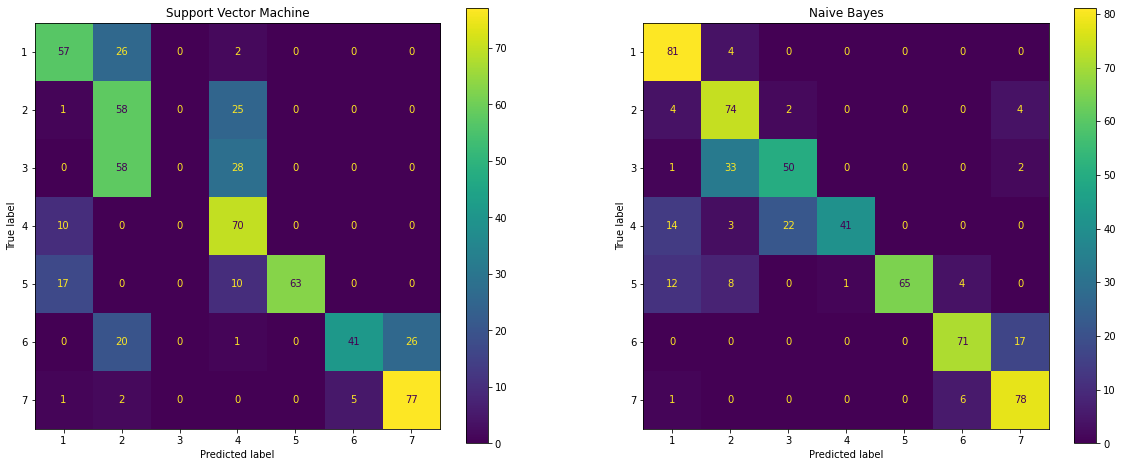

In [26]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import plot_confusion_matrix

# instantiate scaler, fit on training data and scale both train and test data on training data max and min
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train) # one liner to both fit and transform
X_test = scaler.transform(X_test)

# instantiate and fit the two models with default hyperparameters
svc = SVC()
gnb = GaussianNB()

svc.fit(X_train, y_train)
gnb.fit(X_train, y_train)

# compute and print F1 scores
print('SVM F1: {:.03f}'.format(f1_score(y_test, svc.predict(X_test), average='macro')))
print('GNB F1: {:.03f}'.format(f1_score(y_test, gnb.predict(X_test), average='macro')))

# plot confusion matrices, side by side, this time using the sklearn implementation
fig, ax = plt.subplots(1,2, figsize=(20, 8))
plot_confusion_matrix(svc, X_test, y_test, ax=ax[0])
ax[0].set_title('Support Vector Machine')
plot_confusion_matrix(gnb, X_test, y_test, ax=ax[1])
ax[1].set_title('Naive Bayes')

Both models with combined data modalities perform better than the predictions by using single modes of data. The SVM classifier outperforms the depth image approach by only a small margin. Naive Bayes is closer to the scores reported in the paper for individual modalities at a pretty impressive 0.764, although it does fall short of the best performing approaches. 

Looking at the confusion matrix, naive bayes performs relatively well across all classes. The most difficulties are met with the minority classes 4 and 5. The support vector machine seems to favour exercise 4, while it does not predict exercise 3 for any instance. Both algorithms appear to have confusion between exercises 7 and 8.

To see, how the different modalities perform, we train new base classifiers and compute the f1 scores for the different data modalities below.

In [28]:
svc.fit(X_train_a, y_train)
gnb.fit(X_train_a, y_train)

print('SVM F1 acceleration: {:.03f}'.format(f1_score(y_test, svc.predict(X_test_a), average='macro')))
print('Naive Bayes F1 acceleration: {:.03f}'.format(f1_score(y_test, gnb.predict(X_test_a), average='macro')))

svc.fit(X_train_d, y_train)
gnb.fit(X_train_d, y_train)

print('SVM F1 depth image: {:.03f}'.format(f1_score(y_test, svc.predict(X_test_d), average='macro')))
print('Naive Bayes F1 depth image: {:.03f}'.format(f1_score(y_test, gnb.predict(X_test_d), average='macro')))

SVM F1 acceleration: 0.392
Naive Bayes F1 acceleration: 0.523
SVM F1 depth image: 0.567
Naive Bayes F1 depth image: 0.527


The results suggest that much of the good performance of naive bayes comes from successfully combining the two different modalities, as the f1 score is much lower on individual data modalities.

Naive bayes performs similarly across both modalities and outperforms the nearest neighbour approach on acceleration data but not depth image data. 

Support vector machine does not seem to be able to utilize the acceleration data, but outperforms naive bayes (and the nearest neighbour approach) on the depth image data. 

# 4. Decision-level fusion for multimodal classification

<a id='task4'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 4.</b>

Use features calculated for each modality in task 3. Choose base classifier for each modality from scikit-learn. Train classifiers for each modality feature presentations separately and combine the outputs in decision level. Evaluate and compare the result on testing dataset. Do the subtasks given as
<br>
<br> 
<p> <b>4.1</b> Use base classifiers of support vector machine (SVM) with RBF-kernel and AdaBoost classifier (with random_state=0). 
Normalize data between 0-1 using the training dataset. Train the base classifiers by tuning the model parameters (<i>C</i> parameter and RBF-kernel <i>gamma</i> in SVM as well as <i>n_estimators</i> and <i>learning_rate</i> in Adaboost) using 10-fold cross-validation on training dataset to find optimal set of parameters (hint: use GridSearchCV from scikit-learn). For grid search use the following values $C = [0.1, 1.0, 10.0, 100.0]$, $gamma=[0.1, 0.25, 0.5, 0.75, 1.0, 2.0]$, $n\_estimators = [50, 100, 500, 1000]$, and $learning\_rate = [0.1, 0.25, 0.5, 0.75,1.0]$. Choose the best parameters and train the classifiers for each modality on whole training dataset. Is there a possibility that classifiers will overfit to training data using this parameter selection strategy? If so, why? </p>
<br>
<p> <b>4.2</b> Predict probabilistic outputs of each trained classifier for both modalities using the test set. </p>
<br>
<p> <b>4.3</b> Combine the probabilistic outputs of different modalities by fixed classification rules: max, min, prod, and sum. Evaluate, compare, and analyse the final combined results using confusion matrices and F1 scores. Show results for each base classifier combinations (i.e., $SVM_{acc}+SVM_{depth}$, $AdaBoost_{acc}+AdaBoost_{depth}$, $SVM_{acc}+AdaBoost_{depth}$, $AdaBoost_{acc}+SVM_{depth}$)</p>
<br>
Document your work, evaluate the results, and analyse the outcomes in each subtasks 4.1-4.3.
    
</div>

We do a similar process of min-max-scaling and fitting models as before. This time we do this separately for the two modalities, and use the GridSearchCV from scikit-learn to tune hyperparameters on a 10-fold cross-validation.

Selecting hyperparameters based on training set performance is essentially fitting parameters to the training data, so theoretically this can cause some degree of overfitting. However, with such a small grid of hyperparameters to choose from and 10 out-of-sample folds, any meaningful overfit is unlikely.

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

# hyperparameters to search from for the SVM approach
param_grid_svc = {
    'C':[0.1, 1.0, 10.0, 100.0], 
    'gamma':[0.1, 0.25, 0.5, 0.75, 1.0, 2.0],
}
# scale
scaler = MinMaxScaler()
X_train_d = scaler.fit_transform(X_train_d)
X_test_d = scaler.transform(X_test_d)

scaler = MinMaxScaler()
X_train_a = scaler.fit_transform(X_train_a)
X_test_a = scaler.transform(X_test_a)

# instantiate models and grid searches, with 10-fold cv and parallel training
# probability=True is required for SVC to be able to produce probabilistic output
svc = SVC(probability=True)
svm_cv_acc = GridSearchCV(svc, param_grid_svc, cv=10, n_jobs=4)
svm_cv_acc.fit(X_train_a, y_train)
print('SVM Acceleration F1: {:.03f}'.format(f1_score(y_test, svm_cv_acc.predict(X_test_a), average='macro')))

svc = SVC(probability=True)
svm_cv_d = GridSearchCV(svc, param_grid_svc, cv=10, n_jobs=4)
svm_cv_d.fit(X_train_d, y_train)
print('SVM Depth Camera F1: {:.03f}'.format(f1_score(y_test, svm_cv_d.predict(X_test_d), average='macro')))

SVM Acceleration F1: 0.512
SVM Depth Camera F1: 0.527


In [30]:
print('Selected parameters for acceleration data:', svm_cv_acc.best_params_)
print('Selected parameters for depth image data:', svm_cv_d.best_params_)

Selected parameters for acceleration data: {'C': 100.0, 'gamma': 1.0}
Selected parameters for depth image data: {'C': 10.0, 'gamma': 1.0}


Hyperparameter tuning improves the performance of the SVM approach on acceleration data by a considerable margin. However, for the depth camera data, the test set performance is slightly worse. 

The best performing hyperparameters for k-fold on training set can be caused by differences between training and test datasets (overfitting or randomness) or the fact that the default hyperparameter gamma for SVC is not in the grid searched from. The default value for gamma for SVC uses 1 / (n_features * X.var()). However, including the default value for gamma in the grid results in the same hyperparameters selected. Thus the decline in performance is caused by differences in the training and test sets. This is not necessary a sign of overfitting hyperparameters, as it can be caused by randomness as well, as the test set is relatively small and individual observations contribute a lot to the f1 score.

Next we perform a similar exercise with the AdaBoost algorithm. Scaling the train and test data was already done above.

In [31]:
# parameters to search from for AdaBoost
param_grid_ada = {'n_estimators':[50,100,500,1000],
    'learning_rate':[0.1,0.25,0.5,0.75,1.0]
}

# instantiate models and grid searches, with 10-fold cv and parallel training
# random_state=0 fixes the random initiation to produce repeatable output. AdaBoost training runs a bit longer
# so we use verbose training to monitor the progress.
ada = AdaBoostClassifier(random_state=0)
cv_ada_acc = GridSearchCV(ada, param_grid_ada, cv=10, n_jobs=4, verbose=True)
cv_ada_acc.fit(X_train_a, y_train)
f1_adaa = f1_score(y_test, cv_ada_acc.predict(X_test_a), average='macro')
print('AdaBoost Acceleration F1: {:.03f}'.format(f1_adaa))

ada = AdaBoostClassifier(random_state=0)
cv_ada_d = GridSearchCV(ada, param_grid_ada, cv=10, n_jobs=4, verbose=True)
cv_ada_d.fit(X_train_d, y_train)
f1_adad = f1_score(y_test, cv_ada_d.predict(X_test_d), average='macro')
print('AdaBoost Depth Camera F1: {:.03f}'.format(f1_adad))

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   53.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.4min finished


AdaBoost Acceleration F1: 0.542
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  6.0min finished


AdaBoost Depth Camera F1: 0.450


AdaBoost outperforms the SVM implementation for acceleration data, but underperforms significantly on depth camera data. 


Finally, we combine predictions from the different modalities with max, min, prod and sum rules.
With two alternative algorithms for both modalities and four combination rules, this results in a total of 2x2x4 = 16 combinations.
We use dictionaries to make iteration and keeping track of the different experiments convenient.

C:\Users\lauri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
C:\Users\lauri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


,max,min,product,sum
adaboost_acc + adaboost_depth,0.549185,0.704499,0.685123,0.643604
svm_acc + adaboost_depth,0.531762,0.680798,0.647026,0.561660
svm_acc + svm_depth,0.601308,0.665685,0.657967,0.614123
adaboost_acc + svm_depth,0.575500,0.633462,0.656037,0.597723


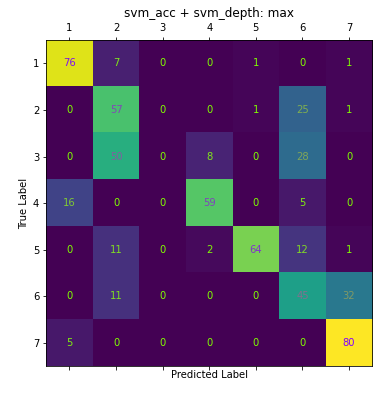

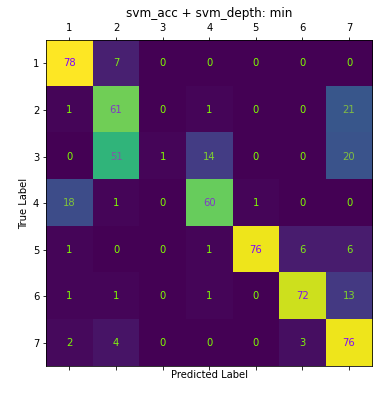

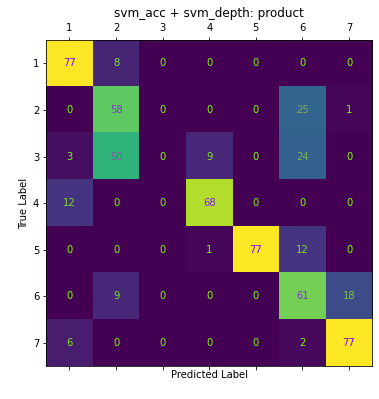

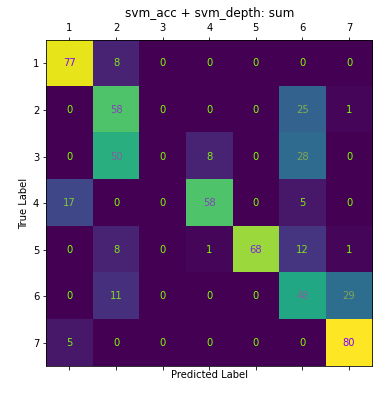

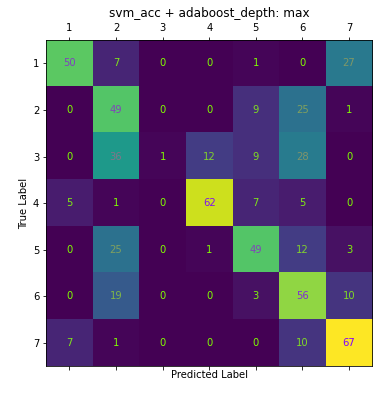

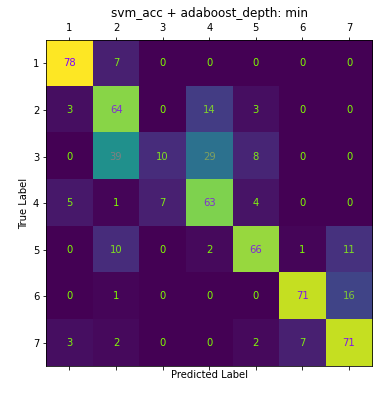

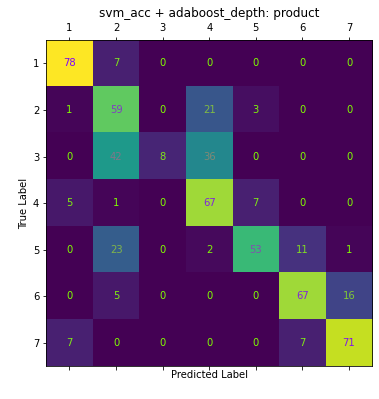

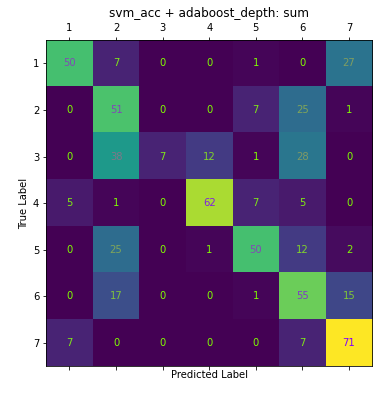

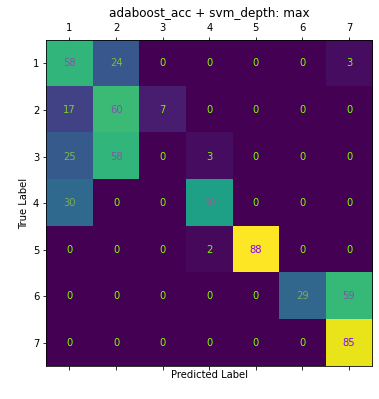

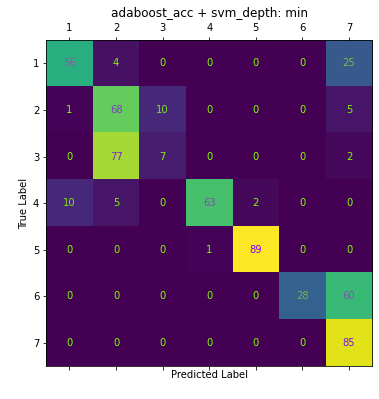

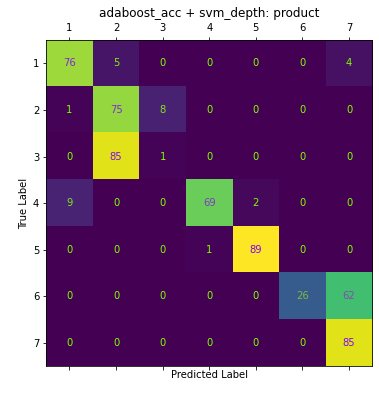

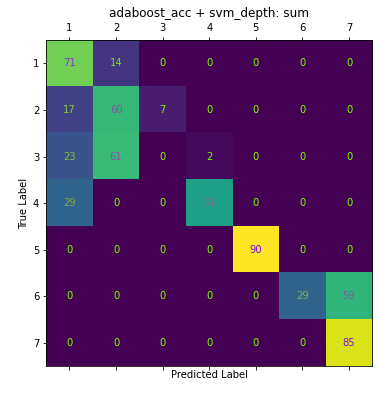

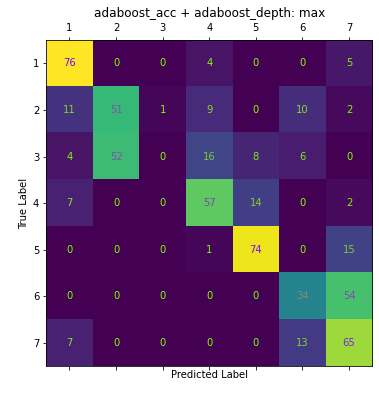

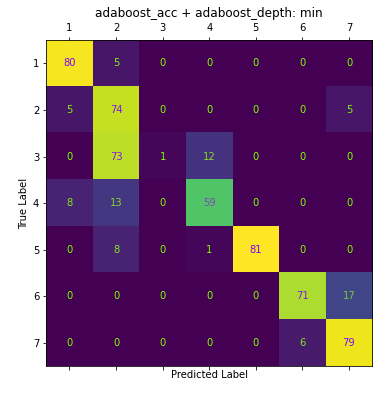

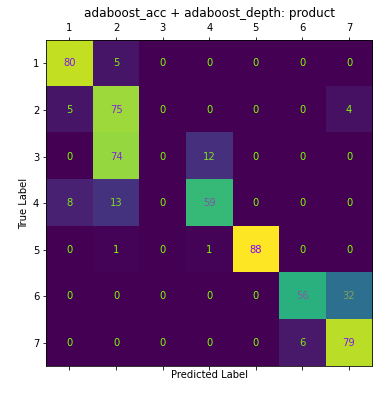

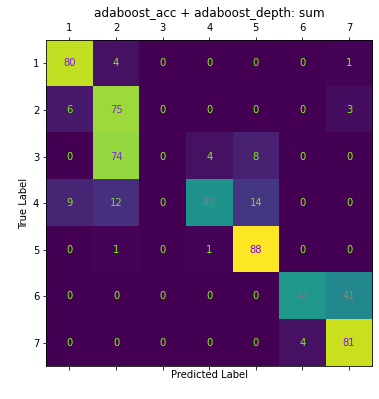

In [43]:
# get probabilistic predictions for the individual classifiers and store them in a dictionary
svm_proba_a = svm_cv_acc.predict_proba(X_test_a)
ada_proba_a = cv_ada_acc.predict_proba(X_test_a)
svm_proba_d = svm_cv_d.predict_proba(X_test_d)
ada_proba_d = cv_ada_d.predict_proba(X_test_d)

proba_outputs = {
    'svm_acc':svm_proba_a,
    'svm_depth':svm_proba_d,
    'adaboost_acc':ada_proba_a,
    'adaboost_depth':ada_proba_d,
}

# dictionary to store the f1 scores
f1_scores = {}

# functions to use for combination rules
functions = {
    'max':np.max,
    'min':np.min,
    'product': np.prod,
    'sum': np.sum
}


# iterate over dictionary keys to the 2 acceleration data classifiers
for acc_clf in ['svm_acc', 'adaboost_acc']:
    # iterate over dictionary keys to the 2 depth image data classifiers
    for depth_clf in ['svm_depth','adaboost_depth']:
        # initiate a nested dict to store the f1 scores for the combination
        f1_scores[f'{acc_clf} + {depth_clf}'] = {}
    
        # combine the probability outputs of the two classifiers
        # to a numpy array with dimensions (2 x n_test x 8)
        prob_comb = np.array([proba_outputs[acc_clf], proba_outputs[depth_clf]])
        
        # for each combination rule, compute the classification output
        # compute and store f1 scores and plot confusion matrix
        for func_name, func in functions.items():
            # combine probabilities by selected rule along the first axis to produce (n_test x 8) output
            probs = func(prob_comb, axis=0)
            # get the index of column with the highest probability output
            # adding 1 to argmax output  is a fast trick to transfer to class numbers
            preds = np.argmax(probs, 1) + 1 
            # compute f1 score and store to dict
            f1_scores[f'{acc_clf} + {depth_clf}'][f'{func_name}'] = f1_score(y_test, preds, average='macro')
            # using the custom confusion matrix plotting function defined earlier
            plot_confusion_matrix_custom(y_test, preds, f'{acc_clf} + {depth_clf}: {func_name}')

# convert f1 scores to dataframe for pretty output
f1_scores = pd.DataFrame(f1_scores).T
# sort rows by the highest f1 score on the row
f1_scores.loc[f1_scores.max(1).sort_values(ascending=False).index,:]

None of the combinations can reach the ~0.76 f1 score of  Naive Bayes classifier with combined data, that was used earlier in section 3. Also, the results underperform results reported in the original paper.

The best combination across all combination rules is the combination of the two adaboost classifiers.
Of the combination rules, best performance, is produced by the minimum rule, with the highest F1 score at ~0.70 for the combination of the two AdaBoost classifiers. The fact that min and product rule significantly outperform max and sum rules could potentially hint at the fitted estimators being overconfident in their predictions at times.

Looking at the confusion matrices, almost all combinations misclassify all exercise 3 instances as exercise 2. This is the source of a significant amount of misclassifications by the best performing combination. It would be interesting to further pursue feature engineering that might enable us to separate between the two classes. but that is beyond the scope of this exercise.

As an aside, we also compute f1 scores for the full set of possible combinations for the four classifiers, such that different classifiers with the same data modality can be used.

In [57]:
from itertools import combinations
f1_scores = {}
# use 2-4 classifiers
for i in range(2,5):
    # iterate over possible combinations with a given number of classifiers in the combination
    for keys in combinations(proba_outputs.keys(), i):
        f1_scores[f'{keys}'] = {}
        prob_comb = np.array([proba_outputs[k] for k in keys])
        # iterate over aggregation rules
        for func_name, func in functions.items():
            probs = func(prob_comb, axis=0)
            preds = np.argmax(probs, 1)+1
            f1_scores[f'{keys}'][f'{func_name}'] = f1_score(y_test, preds, average='macro')
            
f1_scores = pd.DataFrame(f1_scores).T
f1_scores.loc[f1_scores.max(1).sort_values(ascending=False).index,:]

,max,min,product,sum
"('svm_acc', 'svm_depth', 'adaboost_acc', 'adaboost_depth')",0.602555,0.686180,0.717082,0.651638
"('adaboost_acc', 'adaboost_depth')",0.549185,0.704499,0.685123,0.643604
"('svm_acc', 'svm_depth', 'adaboost_depth')",0.601308,0.672899,0.689740,0.641664
"('svm_acc', 'adaboost_acc', 'adaboost_depth')",0.536765,0.673600,0.681979,0.576061
"('svm_acc', 'adaboost_depth')",0.531762,0.680798,0.647026,0.561660
"('svm_acc', 'svm_depth', 'adaboost_acc')",0.602555,0.679316,0.638365,0.615830
"('svm_depth', 'adaboost_acc', 'adaboost_depth')",0.575500,0.668834,0.656850,0.595421
"('svm_acc', 'svm_depth')",0.601308,0.665685,0.657967,0.614123
"('svm_depth', 'adaboost_acc')",0.575500,0.633462,0.656037,0.597723
"('svm_acc', 'adaboost_acc')",0.541659,0.571023,0.571400,0.567760


The best result is achieved by using the product rule, and a combination of all four classifiers. This is only a slight improvement and provides. Overall, the min rule and product rule outperform seem to outperform the other combination rules. As the number of classifiers increases, the product rule should generally work better, as it does not disregard probability information to the extent that the min rule does. Good performance generally requires models trained on both data modalities, and it appears that multiple models trained on the same modality do not provide very much added benefit.

# 5. Bonus task: Multimodal biometric identification of persons (optional)

<a id='task5'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 5.</b>

Can you build a classifier that recognizes the person who is performing the exercise? Use same 10 person dataset and split it so that first 25% of each long exercise sequence is used for training and rest 75% of each sequence is used for testing the classifier. Use same 5 second windowing with 3 seconds overlap to prepare the examples. Note that, now the person identity is the class label instead of exercise type. Max. 10 points are given but you can earn points from partial solution, as well.
<br> 
<br> 
<p> <b>5.1</b> Build a classifier to identify persons based on the features and one of the models given in task 4 (max. 5 points).</p>
<br> 
<p> <b>5.2</b> Can you build your own solution (using new features, new classification model or different fusion approaches) to beat the approach in Task 5.1 ? (max. 5 points) </p>
<br>  
Document your work. Evaluate and compare the results using confusion matrix and F1 score.

</div>

### Identifying subjects based on step 4

For identifying subjects, we need to construct new training and test datasets, that both contain data on all the study participants. Each exercise is based on time with a 25%/75% split.

Note that we make the assumption that ex

The time information is available in the index of the original accelData dataframe. We first compute a timepos variable that represents the percentile of the current observation to the current exercise.

In [82]:
timepos = accelData.groupby(['subjectId','exerciseId'])[0].transform(lambda x: x/x.max())
accelData['timepos'] = timepos.values
timepos = depthData.groupby(['subjectId','exerciseId'])[0].transform(lambda x: x/x.max())
depthData['timepos'] = timepos.values

The time windows that we constructed in the earlier steps are overlapping and there are not many observations. To ensure that there is no leakage of information, we require that the time position is the 25th percentile of the series and the first time series observation of the test data is over the 25th percentile.

In [83]:
# construct a boolean mask for acceleration data
train_ids = (accelData.groupby(['tsId'])['timepos'].agg('max') < 0.25)
# combine with a boolean mask for depth image data
train_ids = train_ids&(depthData.groupby(['tsId'])['timepos'].agg('max') < 0.25)
# get tsId values where the boolean mask is true
train_ids = train_ids[train_ids].index
# filter acceleration and depth image data and based on whether the tsId is in the selected tsIds
trainAccel = accelData[accelData.tsId.isin(train_ids)]
trainDepth = depthData[depthData.tsId.isin(train_ids)]

# repeat the same for test data
test_ids = (accelData.groupby(['tsId'])['timepos'].agg('min') > 0.25)
test_ids = test_ids&(depthData.groupby(['tsId'])['timepos'].agg('min') > 0.25)
test_ids = test_ids[test_ids].index
testAccel = accelData[accelData.tsId.isin(test_ids)]
testDepth = depthData[depthData.tsId.isin(test_ids)]

We also need to define a new label series, based on the subjectId. We can do so by similarly dropping duplicated tsId observations and getting the respective subjectId values.

We also repeat the resampling, and index setting for the train and test datasets that we did earlier.

In [84]:
y_train = trainAccel.loc[~trainAccel.tsId.duplicated(), 'subjectId'].values
y_test = testAccel.loc[~testAccel.tsId.duplicated(), 'subjectId'].values

trainAccel = resample_accel(trainAccel)
testAccel = resample_accel(testAccel)


trainDepth = trainDepth.set_index('tsId')[range(1, 193)]
testDepth = testDepth.set_index('tsId')[range(1, 193)]

Next we need to conduct the pca transformation for our new training and test datasets.
The implementation follows exactly the implementation earlier.

In [85]:
X_train_a = []
X_test_a = []
for i in range(1, 4):
    tr_X = index_unstack(trainAccel[i].copy())
    ts_X = index_unstack(testAccel[i].copy())
    tr_X, ts_X = pca_lda_transform(tr_X, ts_X, n_components=10, lda=False)
    X_train_a.append(tr_X)
    X_test_a.append(ts_X)

X_train_a = np.hstack(X_train_a)
X_test_a = np.hstack(X_test_a)
# add aggregations
X_train_a = np.hstack([X_train_a, trainAccel.groupby('tsId').agg(['mean','std'])])
X_test_a =  np.hstack([X_test_a, testAccel.groupby('tsId').agg(['mean','std'])])

X_train_d = []
X_test_d = []
for i in range(5):
    tr_X = trainDepth.iloc[i::5,]
    ts_X = testDepth.iloc[i::5,]
    tr_X, ts_X = pca_lda_transform(tr_X, ts_X, n_components=10, lda=False)
    X_train_d.append(tr_X)
    X_test_d.append(ts_X)

X_train_d = np.hstack(X_train_d)
X_test_d = np.hstack(X_test_d)

print('Training data shapes',
      '\nAcceleration: ', X_train_a.shape, '\nDepth image:',
     X_train_d.shape)
print('Test data shapes',
      '\nAcceleration: ', X_test_a.shape, '\nDepth image:',
     X_test_d.shape)

Training data shapes 
Acceleration:  (407, 36) 
Depth image: (407, 50)
Test data shapes 
Acceleration:  (1489, 36) 
Depth image: (1489, 50)


Notably, because 75% of each series is left for testing, we have significantly fewer observations available. 

Our data is ready for the ML models. We elect to use a combination of the Support Vector Machine models, with hyperparamters tuned on the same hyperparameter grid as in step 4. For complemeteness, we also report f1 scores for individual modalities.

SVM Acceleration F1: 0.747
SVM Depth Image F1: 0.843


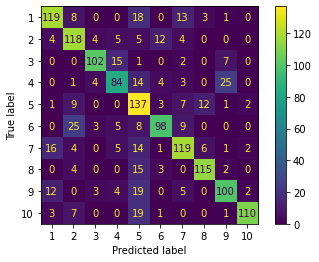

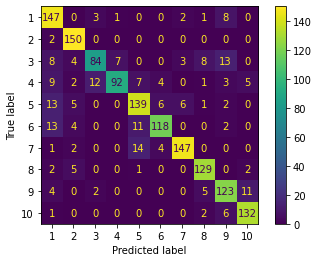

In [93]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
param_grid_svc = {
    'C':[0.1,1.0,10.0,100.0], 
    'gamma':[0.1,0.25,0.5,0.75,1.0,2.0],
}

scaler = MinMaxScaler()
X_train_d = scaler.fit_transform(X_train_d)
X_test_d = scaler.transform(X_test_d)
scaler = MinMaxScaler()
X_train_a = scaler.fit_transform(X_train_a)
X_test_a = scaler.transform(X_test_a)
svc = SVC(probability=True)

svm_cv_acc = GridSearchCV(svc, param_grid_svc, cv=10, n_jobs=4)
svm_cv_acc.fit(X_train_a, y_train)
f1_tmp = f1_score(y_test, svm_cv_acc.predict(X_test_a), average='macro')
print('SVM Acceleration F1: {:.03f}'.format(f1_tmp))


svm_cv_d = GridSearchCV(svc, param_grid_svc, cv=10, n_jobs=4)
svm_cv_d.fit(X_train_d, y_train)
f1_tmp = f1_score(y_test, svm_cv_d.predict(X_test_d), average='macro')
print('SVM Depth Image F1: {:.03f}'.format(f1_tmp))

plot_confusion_matrix(svm_cv_acc, X_test_a, y_test)
plot_confusion_matrix(svm_cv_d, X_test_d, y_test)

Going by the f1 scores, the subject identification task appears to be much easier than the exercise identification, with relatively high f1 scores for both data modalities. I find this interesting, considering that my own intuition would suggest that identifying users would be a relatively difficult task on this type of data.


Looking at the confusion matrices, there are not as clear failure modes for the models, other than the model trained on acceleration data overpredicting subject 5.

For completeness, before forming an ensemble of these models, we also compute the f1 scores for the best performing Naive Bayes approach from step 3 and the AdaBoost from step 4.

In [96]:
# stack for gaussian NB model
X_train = np.hstack([X_train_a, X_train_d])
X_test = np.hstack([X_test_a, X_test_d])

gnb = GaussianNB()
gnb.fit(X_train, y_train)
f1_tmp = f1_score(y_test, gnb.predict(X_test), average='macro')
print('F1 Score for Naive Bayes: {:.03f}'.format(f1_tmp))

# parameters to search from for AdaBoost
param_grid_ada = {'n_estimators':[50,100,500,1000],
    'learning_rate':[0.1,0.25,0.5,0.75,1.0]
}
ada = AdaBoostClassifier(random_state=0)
cv_ada_acc = GridSearchCV(ada, param_grid_ada, cv=10, n_jobs=4, verbose=True)
cv_ada_acc.fit(X_train_a, y_train)
f1_adaa = f1_score(y_test, cv_ada_acc.predict(X_test_a), average='macro')
print('AdaBoost Acceleration F1: {:.03f}'.format(f1_adaa))

ada = AdaBoostClassifier(random_state=0)
cv_ada_d = GridSearchCV(ada, param_grid_ada, cv=10, n_jobs=4, verbose=True)
cv_ada_d.fit(X_train_d, y_train)
f1_adad = f1_score(y_test, cv_ada_d.predict(X_test_d), average='macro')
print('AdaBoost Depth Camera F1: {:.03f}'.format(f1_adad))

F1 Score for Naive Bayes: 0.584
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   26.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  2.3min finished


AdaBoost Acceleration F1: 0.384
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   31.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  2.7min finished


AdaBoost Depth Camera F1: 0.476


Based on the individual F1 scores, which are significantly lower than for the SVM approach, it is unlikely that these models would make a meaningful positive contribution to model performance on the subject identification task. 

To complete our final benchmark approach, we ensemble the SVM models trained on the two data modalities using different combination rules, and plot the confusion matrix for the best performing one.

C:\Users\lauri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
C:\Users\lauri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


,max,min,product,sum
SVM_acc + SVM_depth,0.898404,0.897547,0.928666,0.91546


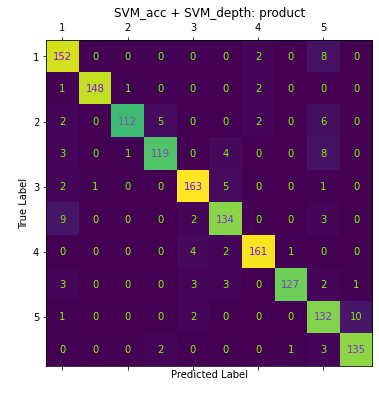

In [99]:
svm_proba_a = svm_cv_acc.predict_proba(X_test_a)
svm_proba_d = svm_cv_d.predict_proba(X_test_d)
f1_scores = {}
prob_comb = np.array([svm_proba_a, svm_proba_d])
for func_name, func in functions.items():
    probs = func(prob_comb, axis=0)
    preds = np.argmax(probs, 1) + 1 
    f1_scores[f'{func_name}'] = f1_score(y_test, preds, average='macro')

score_table = pd.DataFrame(pd.Series(f1_scores, name='SVM_acc + SVM_depth')).T
# plot the best one
probs = functions[score_table.idxmax(1)[0]](prob_comb, axis=0)
preds = np.argmax(probs, 1) + 1 
plot_confusion_matrix_custom(y_test, preds, f'SVM_acc + SVM_depth: {score_table.idxmax(1)[0]}')
score_table

The highest f1 score is a much improved ~0.929, achieved with combining SVM classifiers using the product rule. 

## Own approach

As a final step, I propose my own approach for feature generation.

This task is quite different from the earlier task, in that relevant features for identifying an exercise and the participant are vastly different. I argue that, because subjects are performing different kinds of exercises, aggregations on the data are more important and e.g. preserving time-ordering is not necesary.

For simplicity, we first make the assumption here, that we have no information on the exercise that the current subject is performing. I later conclude with constructing a simple extension of the approach that assumes that information on the exercise performed is available, and utilizes it.

As we compute aggregations and PCA on the acceleration data, resampling the data essentially arbitrarily casts away some information. Therefore we use the original acceleration data with 500 observations for each window.

In [112]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy import stats

# reset the acceleration data from the resampled one to the original
trainAccel = accelData.loc[accelData.tsId.isin(train_ids), ['tsId'] + list(range(1,4))]
testAccel = accelData.loc[accelData.tsId.isin(test_ids), ['tsId'] + list(range(1,4))]
trainAccel.set_index('tsId', inplace=True)
testAccel.set_index('tsId', inplace=True)

We first, compute standard descriptive statistics for each window on both modalities.
This approach could be likened to a deep feature synthesis approach (https://dai.lids.mit.edu/wp-content/uploads/2017/10/DSAA_DSM_2015.pdf).

For the acceleration data, we do this separately for each axis.
For the image data, we treat the entire pixel space of the 5 images for each window, and compute aggregations. Doing this separately, is unlikely to contain much meaningful information with regards to subject identification.

I also experimented with some further aggregations. This include other quantiles than median, variance, skewness and kurtosis. In addition, I experimented with aggregations of first order differences on the acceleration data. These experiments produced no improvement in cross-validation f1 scores.

In [114]:
# list of aggregations
aggs = [np.mean, np.median, np.max, np.min, np.std]

# compute the aggregations via pandas groupby
X_train_a_aggs = trainAccel.groupby('tsId').agg(aggs).values
X_test_a_aggs = testAccel.groupby('tsId').agg(aggs).values

# For the depth image data we take the same operations on a numpy array version
# of the data, because numpy aggregation operations default to a global computation
# on a numpy array. The resulting list is transformed to a pandas
# series to produce a dataframe output.
X_train_d_aggs = trainDepth.groupby('tsId').apply(lambda x: pd.Series([f(x.values) for f in aggs]))
X_test_d_aggs = testDepth.groupby('tsId').apply(lambda x: pd.Series([f(x.values) for f in aggs]))

Next we reduce the dimensionality of the data via PCA.

For the acceleration data, doing this separately for each axis does not provide added benefit and add noise to feature selection. Because of this we run pca on the full 3 x 500 data matrix for each window, stacked to a feature vector with 1500 features.

We similarly stack the image data for each window to a vector with 5 x 192 = 960 features.

The selected n_components 10 and 20 for the acceleration data and depth image data respectively are a result of some hand tuning.

In [120]:
pca_a = Pipeline([
    ('scl', StandardScaler()),
    ('pca', PCA(10))
])

# take all 500 observations for each variable and stack them horizontally to create
# data matrices with 500*3 = 1500 columns
X_train_a_pc = np.hstack([trainAccel.iloc[i::500] for i in range(500)])
X_test_a_pc = np.hstack([testAccel.iloc[i::500] for i in range(500)])
X_train_a_pc = pca_a.fit_transform(X_train_a_pc)
X_test_a_pc = pca_a.transform(X_test_a_pc)

X_train_d_pc = np.hstack([trainDepth.iloc[i::5] for i in range(5)])
X_test_d_pc = np.hstack([testDepth.iloc[i::5] for i in range(5)])

pca_d = Pipeline([
    ('scl', StandardScaler()),
    ('pca', PCA(20))
])

X_train_d_pc = pca_d.fit_transform(X_train_d_pc)
X_test_d_pc = pca_d.transform(X_test_d_pc)


# finally stack the data horizontally to form a final set of 50 features.
X_train = np.hstack([X_train_a_aggs, X_train_a_pc, X_train_d_pc, X_train_d_aggs])
X_test = np.hstack([X_test_a_aggs, X_test_a_pc, X_test_d_pc, X_test_d_aggs])
print(X_train.shape)
print(X_test.shape)

(407, 50)
(1489, 50)


Our combined training dataset is ready for modeling. We scale the data to range 0,1 using sklearn MinMaxScaler and fit three different models. The SVM and Naive Bayes models act as a benchmark.

Random Forest is itself an ensemble method, so we don't use external combination rules, but rather the whola

SVM F1: 0.956
Naive Bayes F1: 0.740
Random Forest F1: 0.983


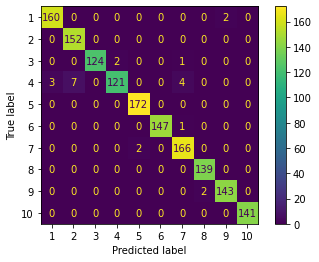

In [121]:
from sklearn.ensemble import RandomForestClassifier
rf_params = {'criterion': 'entropy',
             'max_depth': 15,
             'n_estimators': 900}

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svc = SVC()
svc_grid = GridSearchCV(svc, param_grid_svc, cv=10, n_jobs=4)


gnb = GaussianNB()
rf_cv = RandomForestClassifier(random_state=0, **rf_params)

svc_grid.fit(X_train, y_train)
gnb.fit(X_train, y_train)
rf_cv.fit(X_train, y_train)


f1_tmp = f1_score(y_test, svc_grid.predict(X_test), average='macro')
print('SVM F1: {:.03f}'.format(f1_tmp))
f1_tmp = f1_score(y_test, gnb.predict(X_test), average='macro')
print('Naive Bayes F1: {:.03f}'.format(f1_tmp))
f1_tmp = f1_score(y_test, rf_cv.predict(X_test), average='macro')
print('Random Forest F1: {:.03f}'.format(f1_tmp))
plot_confusion_matrix(rf_cv, X_test, y_test)

The final model with the three combined prepared data reach a near-perfect f1 score of 0.983 on the out-of-fold test set.
It is not likely very meaningful to further tune this model.

As a final step, we incorporate a very simple approach, that takes into account. This is done

Random Forest F1: 0.989


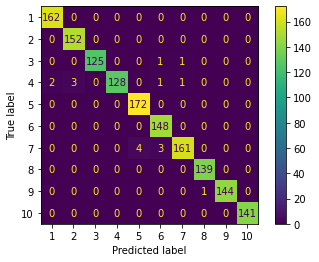

In [122]:
# a dummy encoded representation of the exercise performed
tr_dums = pd.get_dummies(pd.Series(trainAccel.index.unique()).str.split('_').str[1].astype(int))
ts_dums = pd.get_dummies(pd.Series(testAccel.index.unique()).str.split('_').str[1].astype(int))

trains = []
tests = []
# for each column in the dummy representation multiply the 
for col in tr_dums:
    tr = X_train * tr_dums[col].values[:,np.newaxis]
    trains.append(tr)
    ts = X_test * ts_dums[col].values[:, np.newaxis]
    tests.append(ts)
X_train = np.hstack([X_train] + trains)
X_test = np.hstack([X_test] + tests)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf_cv = RandomForestClassifier(random_state=0, **rf_params)
rf_cv.fit(X_train, y_train)

f1_tmp = f1_score(y_test, rf_cv.predict(X_test), average='macro')
print('Random Forest F1: {:.03f}'.format(f1_tmp))
plot_confusion_matrix(rf_cv, X_test, y_test)

Encoding the exercise information in a simple way into the training data further improves the model accuracy to 0.989 with only 17 test examples with incorrectly predicted labels.